In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from wordcloud import WordCloud

# Understanding the dataset

In [82]:
data = pd.read_csv("data/train.csv")
data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


**In the 'label' column:**
- 1 is unreliable
- 0 is reliable

Now, let us check for any missing values and display basic statistics of the dataset

In [83]:
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB
None
                 id         label
count  20800.000000  20800.000000
mean   10399.500000      0.500625
std     6004.587135      0.500012
min        0.000000      0.000000
25%     5199.750000      0.000000
50%    10399.500000      1.000000
75%    15599.250000      1.000000
max    20799.000000      1.000000


The distribution of the 'label' column is shown below

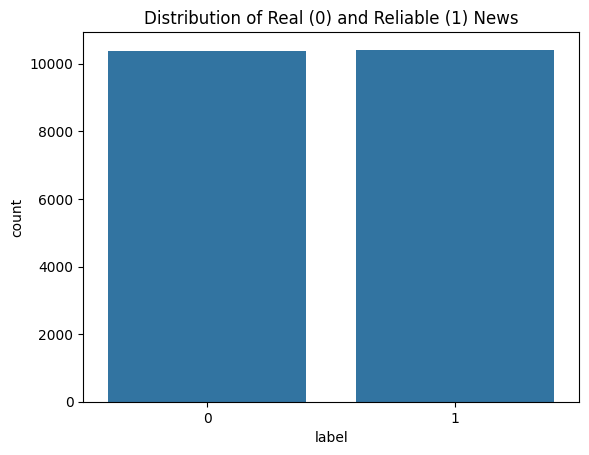

In [8]:
sns.countplot(x='label', data=data)

plt.title('Distribution of Real (0) and Reliable (1) News')
plt.show()

The count plot above shows that fake and real news is in equal distribution within the dataset.

# Cleaning the data 

The dataset contains some null values. Since only 39 of 20800 (0.19%) entries of the text column are not null, I will delete these samples. For now, I will disregard any other column entries which hold null values.

Let us visualise the percentage of null values of each column.

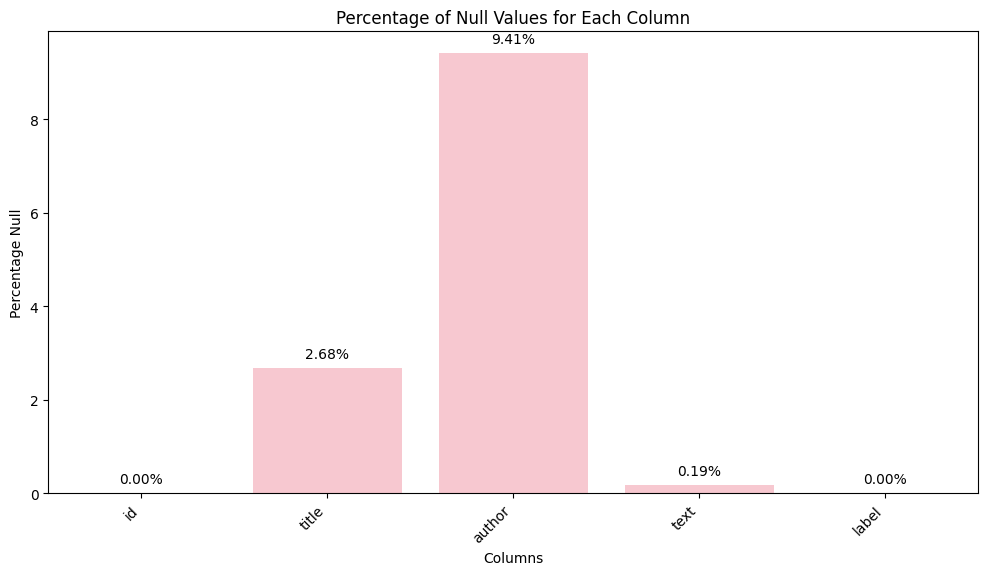

In [9]:
null_percentage = (data.isnull().sum() / len(data)) * 100

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=null_percentage.index, y=null_percentage.values, color='pink')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.xticks(rotation=45, ha='right')
plt.title('Percentage of Null Values for Each Column')
plt.xlabel('Columns')
plt.ylabel('Percentage Null')
plt.show()

In [84]:
data.dropna(subset=['text'], inplace=True)

print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 20761 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20761 non-null  int64 
 1   title   20203 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20761 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 973.2+ KB
None
                 id         label
count  20761.000000  20761.000000
mean   10401.130341      0.499687
std     6005.142716      0.500012
min        0.000000      0.000000
25%     5201.000000      0.000000
50%    10401.000000      0.000000
75%    15603.000000      1.000000
max    20799.000000      1.000000


Here, we have reduced the number of samples to 20761 (the number of non-null samples of the text column) from 20800.

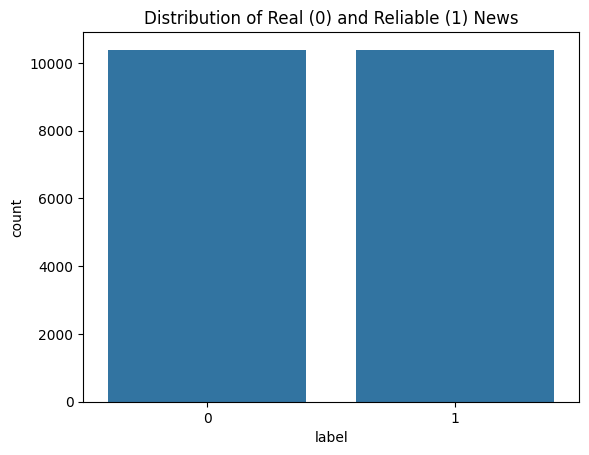

In [11]:
sns.countplot(x='label', data=data)

plt.title('Distribution of Real (0) and Reliable (1) News')
plt.show()

# Visualising Reliability

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

In [32]:
reliable_news = data[data['label'] == 0]['text']
unreliable_news = data[data['label'] == 1]['text']

## Word Clouds

In [33]:
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

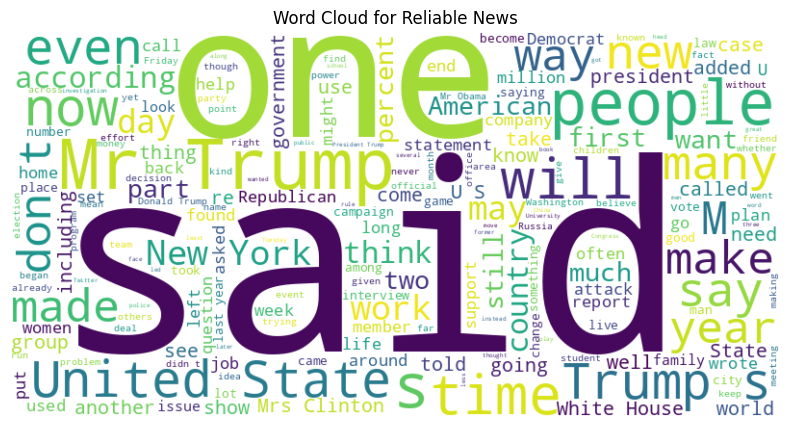

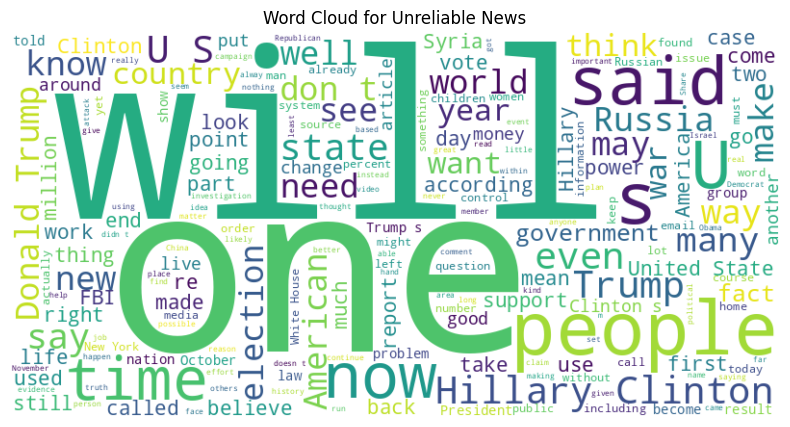

In [45]:
reliable_news_text = ' '.join(reliable_news)
generate_word_cloud(reliable_news_text, 'Word Cloud for Reliable News')

unreliable_news_text = ' '.join(unreliable_news)
generate_word_cloud(unreliable_news_text, 'Word Cloud for Unreliable News')

## Plotting Most Common Words

In [38]:
def plot_most_common_words(text, title):
    vectorizer = CountVectorizer(stop_words='english')
    word_counts = vectorizer.fit_transform(text)

    word_counts_sum = word_counts.sum(axis=0)

    feature_names = vectorizer.get_feature_names_out()

    word_counts_df = pd.DataFrame({'Word': feature_names, 'Count': word_counts_sum.tolist()[0]})
    
    word_counts_df = word_counts_df.sort_values(by='Count', ascending=False)

    plt.figure(figsize=(12, 6))
    plt.bar(word_counts_df['Word'][:20], word_counts_df['Count'][:20])
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Count')
    plt.show()

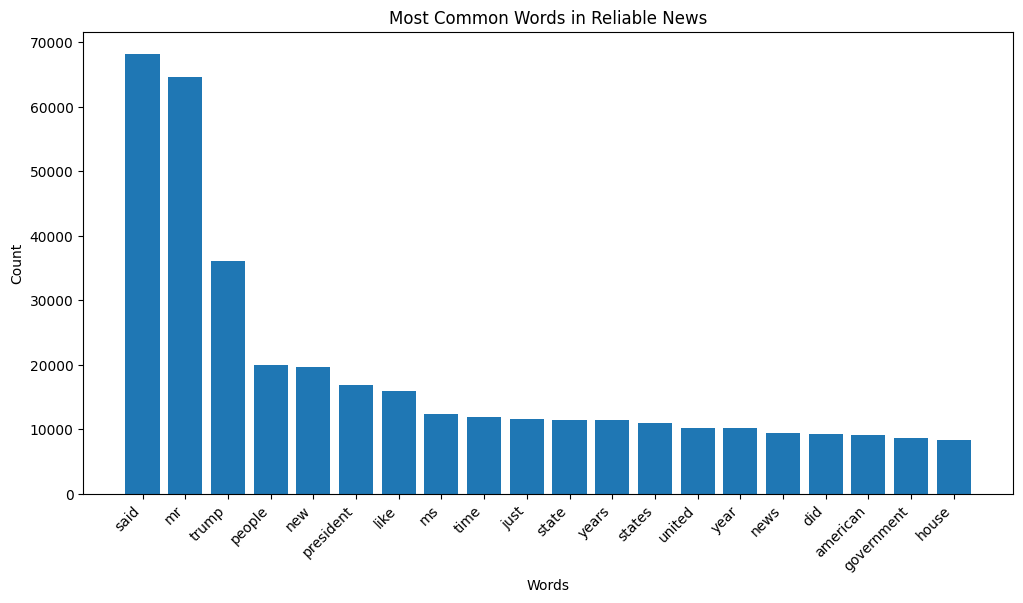

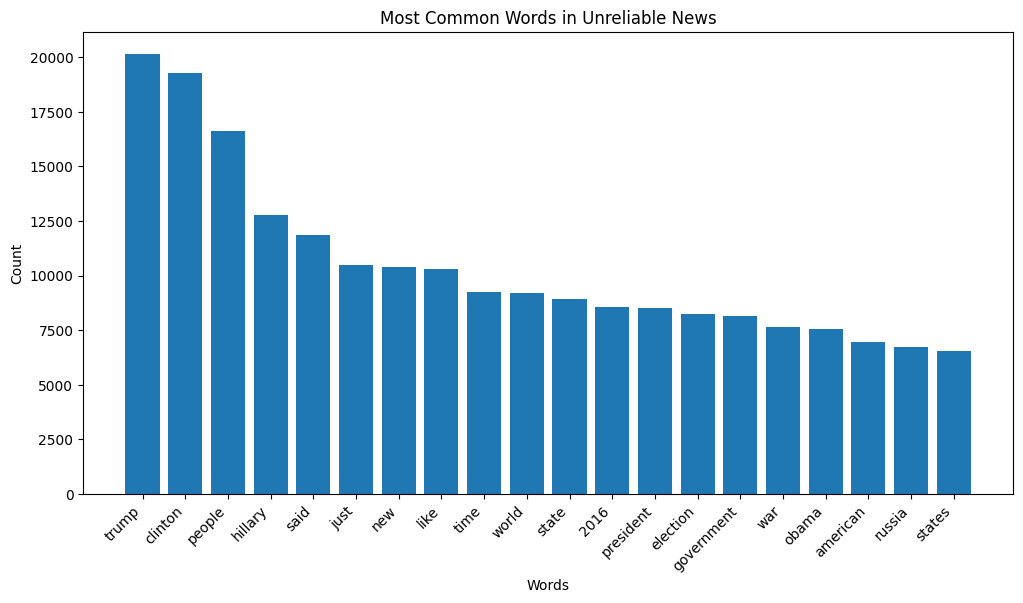

In [44]:
plot_most_common_words(reliable_news, 'Most Common Words in Reliable News')
plot_most_common_words(unreliable_news, 'Most Common Words in Unreliable News')

# N-gram Analysis

In [50]:
import nltk
from nltk import ngrams
from nltk.corpus import stopwords

In [52]:
reliable_news = data[data['label'] == 0]['text']
unreliable_news = data[data['label'] == 1]['text']

In [55]:
def plot_ngrams(text, n, title):
    # tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    vectorizer = CountVectorizer(stop_words=stop_words)
    
    # convert the Series to a string
    text_str = ' '.join(text)
    
    # apply the analyser to the string
    words = vectorizer.build_analyzer()(text_str)

    # generate n-grams
    n_grams = ngrams(words, n)

    # calculate frequency of n-grams
    n_gram_freq = pd.Series(n_grams).value_counts()

    # plot the most common n-grams
    plt.figure(figsize=(12, 6))
    n_gram_freq[:20].plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel(f'{n}-Grams')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.show()

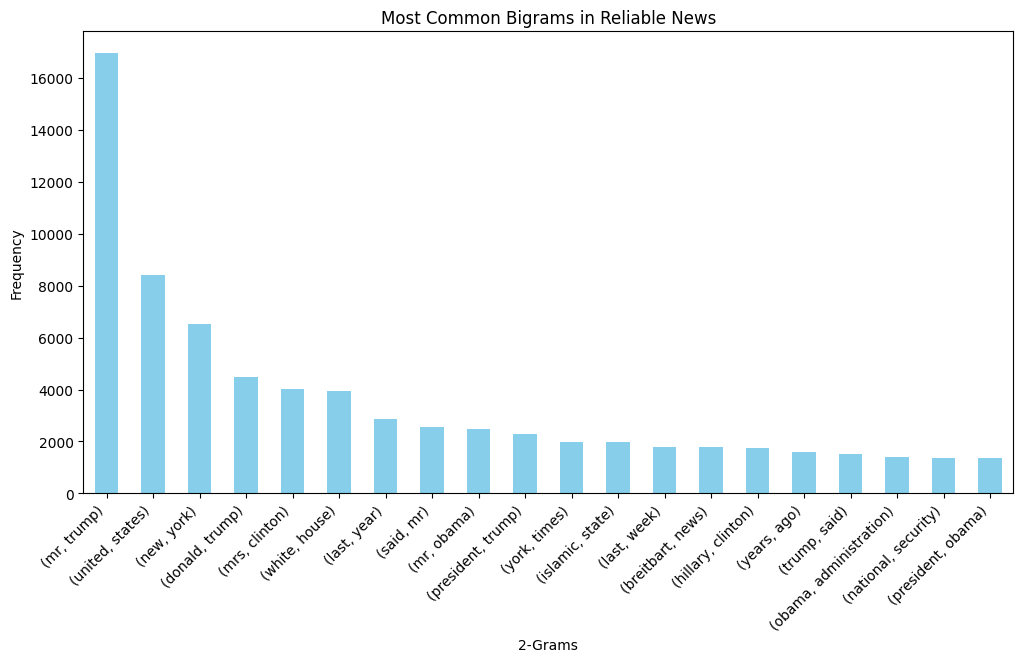

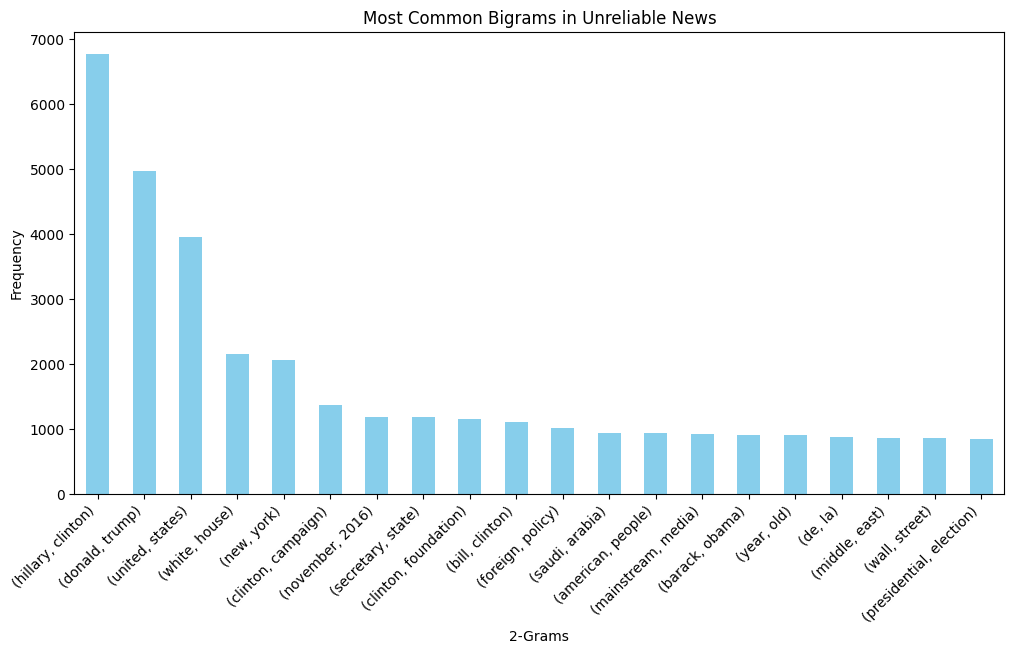

In [56]:
plot_ngrams(reliable_news, 2, 'Most Common Bigrams in Reliable News')

plot_ngrams(unreliable_news, 2, 'Most Common Bigrams in Unreliable News')

# Sentiment Analysis

Sentiment polarity is a numerical measure that indicates the degree of positivity or negativity expressed in a piece of text. It is part of sentiment analysis, which is the process of determining the sentiment or emotional tone conveyed in a given text. Sentiment analysis is often used in natural language processing (NLP) and text mining to understand the subjective information in textual data.ent.

Sentiment polarity is typically measured on a scale, where:

- Positive values indicate positive sentiment such as happiness and approval
- Negative values indicate negative sentiment such as sadness and disapproval 
- Values around zero indicate neutral sentiment


The TextBlob library analyses the sentiment of the given text. The sentiment property provides an object with attributes such as polarity, which represents the sentiment polarity. 

In [59]:
from textblob import TextBlob

In [60]:
def get_sentiment_polarity(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

In [61]:
data['sentiment_polarity'] = data['text'].apply(get_sentiment_polarity)

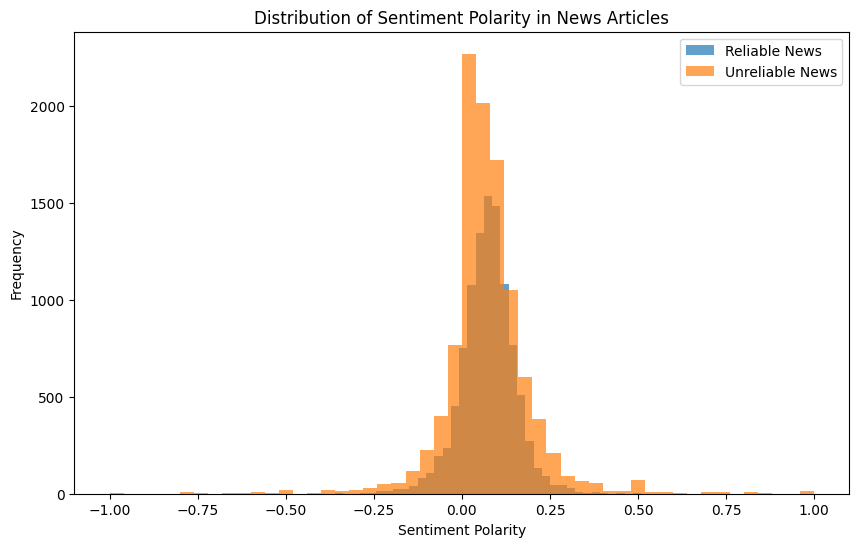

In [62]:
plt.figure(figsize=(10, 6))
plt.hist(data[data['label'] == 0]['sentiment_polarity'], bins=50, label='Reliable News', alpha=0.7)
plt.hist(data[data['label'] == 1]['sentiment_polarity'], bins=50, label='Unreliable News', alpha=0.7)
plt.title('Distribution of Sentiment Polarity in News Articles')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Bag-of-words approach

Let us first start by tokenising and creating a bag-of-words representation of the text of each article.

The TF-IDF will transform the text into meaningful representation of integers or numbers; it measures the originality of a word by comparing the number of times a word appears in each article with the number of articles the word appears in.

This approach represents a document as an unordered set of words, disregarding grammar and word order but keeping track of word frequency. The basic idea is to create a vocabulary of unique words present in the entire set of documents and then represent each document as a vector in this high-dimensional space, with each dimension corresponding to a word in the vocabulary.ry.

This is a simplified explanation of the process:
1. Create Vocabulary: Identify all unique words in the entire set of documents.
2. Tokenisation: Break down each document into individual words.
3. Word Frequency: Count the frequency of each word in each document.
4. Vector Representation: Represent each document as a vector, where each element in the vector corresponds to the frequency of a word in the vocabulary.

However, I will use TF-IDF (Term Frequency-Inverse Document Frequency) to address some of the limitations of bag-of-words. Instead of representing a document as a raw word frequency vector, TF-IDF considers both the frequency of a word in a document (Term Frequency) and the rarity of the word across all documents in the dataset (Inverse Document Frequency).

In [86]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

X = tfidf_vectorizer.fit_transform(data['text'])

Now, I would like to add text length as a feature for each data sample.

In [87]:
data['text_length'] = data['text'].apply(len)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(
    X, data['label'], test_size=0.2, random_state=42
)

# Logistic Regression

In [89]:
logreg_model = LogisticRegression()

logreg_model.fit(X_train, y_train)

LogisticRegression()

Now, I will test the accuracy of the model.

In [90]:
y_pred = logreg_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.95


Since there was an equal distribution of 'reliable' and 'unreliable' news, this score is respectable - where a random guess strategy would yield, on average, a score of 50%. 

Let us compare this to the model's performance on the training set, because it is interesting.

In [91]:
y_pred_train = logreg_model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_train)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.97


The model does not seem to be overfitting as using the test set only reduced accuracy by 2%

### Classification Report

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2079
           1       0.94      0.96      0.95      2074

    accuracy                           0.95      4153
   macro avg       0.95      0.95      0.95      4153
weighted avg       0.95      0.95      0.95      4153



### Confusion Matrix

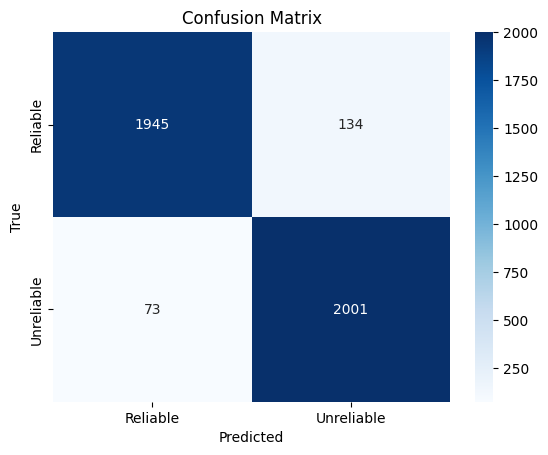

In [20]:
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Reliable', 'Unreliable'], yticklabels=['Reliable', 'Unreliable'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

An interesting thing to observe when combining logistic regression with TF-IDF (bag of words) is the coefficient the model gives to each word. Below, I will visualise the coefficient (weight) of words in determining reliability of a given article.

### Top 10 words indicative of reliable news (according to model)

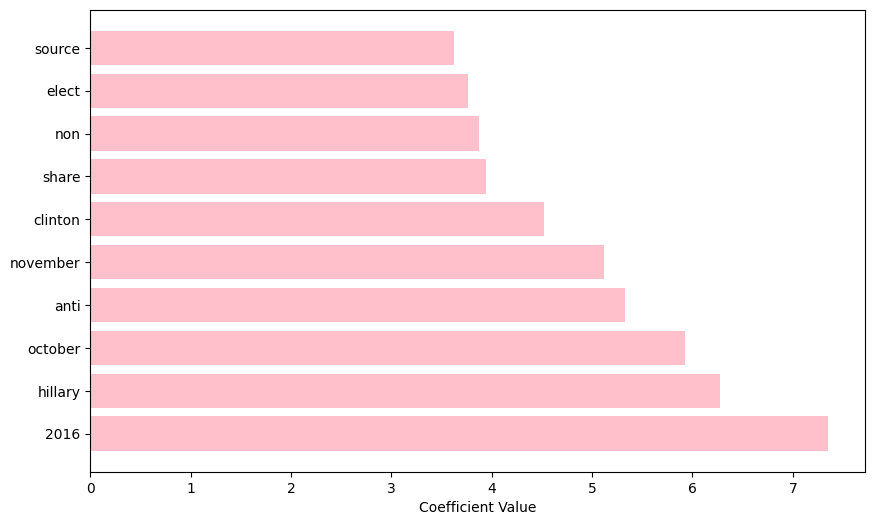

In [21]:
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = logreg_model.coef_.flatten()

feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
top_features = feature_importance.nlargest(10, 'Coefficient')

# print(top_features)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Coefficient'], color='pink')
plt.xlabel('Coefficient Value')
plt.show()

### Word Cloud Representation

This word cloud shows the most common words within articles deemed 'reliable'.

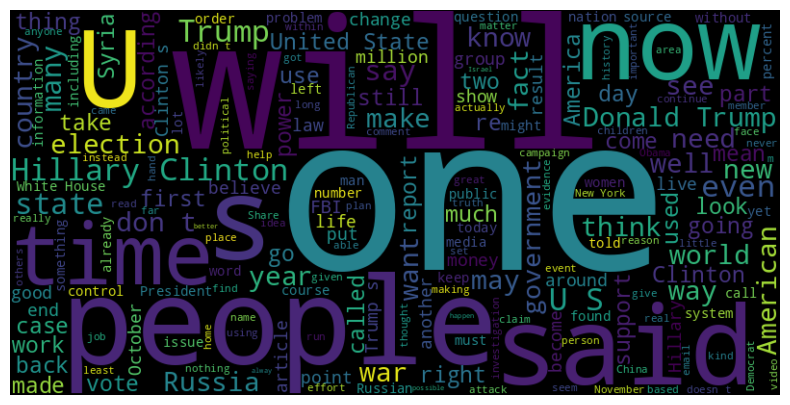

In [22]:
reliable_news_text = ' '.join(data[data['label'] == 1]['text'])
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(reliable_news_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Reliability and Text Length Correlation

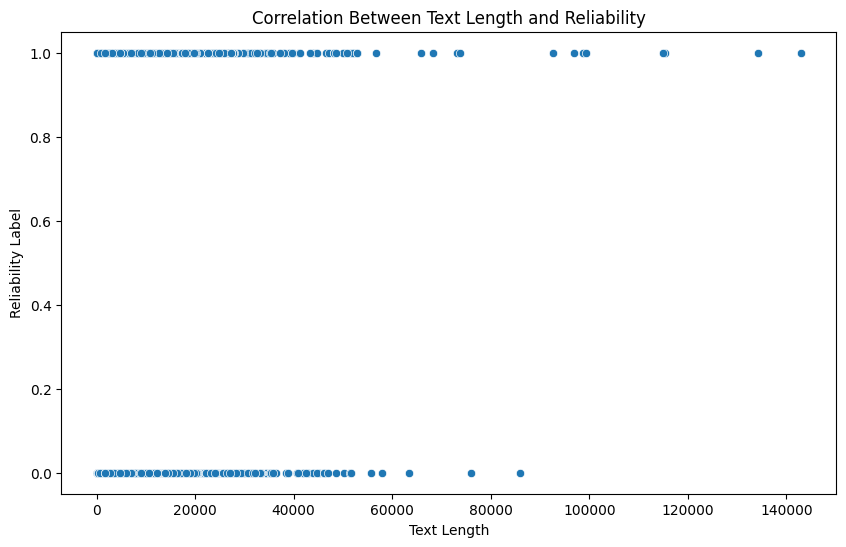

In [92]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='text_length', y='label', data=data)
plt.title('Correlation Between Text Length and Reliability')
plt.xlabel('Text Length')
plt.ylabel('Reliability Label')
plt.show()

# Logistic Regression with Article Title

In [65]:
data = pd.read_csv("data/train.csv")

In [66]:
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB
None
                 id         label
count  20800.000000  20800.000000
mean   10399.500000      0.500625
std     6004.587135      0.500012
min        0.000000      0.000000
25%     5199.750000      0.000000
50%    10399.500000      1.000000
75%    15599.250000      1.000000
max    20799.000000      1.000000


In [67]:
data.dropna(subset=['title'], inplace=True)

print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 20242 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20242 non-null  int64 
 1   title   20242 non-null  object
 2   author  18285 non-null  object
 3   text    20203 non-null  object
 4   label   20242 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 948.8+ KB
None
                 id         label
count  20242.000000  20242.000000
mean   10398.462504      0.486859
std     6001.175875      0.499840
min        0.000000      0.000000
25%     5207.250000      0.000000
50%    10403.500000      0.000000
75%    15584.750000      1.000000
max    20799.000000      1.000000


In [68]:
X = tfidf_vectorizer.fit_transform(data['title'])

In [69]:
data['title_length'] = data['title'].apply(len)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    X, data['label'], test_size=0.2, random_state=42
)

In [71]:
logreg_model = LogisticRegression()

logreg_model.fit(X_train, y_train)

LogisticRegression()

In [72]:
y_pred = logreg_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.92


In [73]:
y_pred_train = logreg_model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_train)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.94


In [74]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91      2071
           1       0.86      0.99      0.92      1978

    accuracy                           0.92      4049
   macro avg       0.92      0.92      0.92      4049
weighted avg       0.93      0.92      0.92      4049



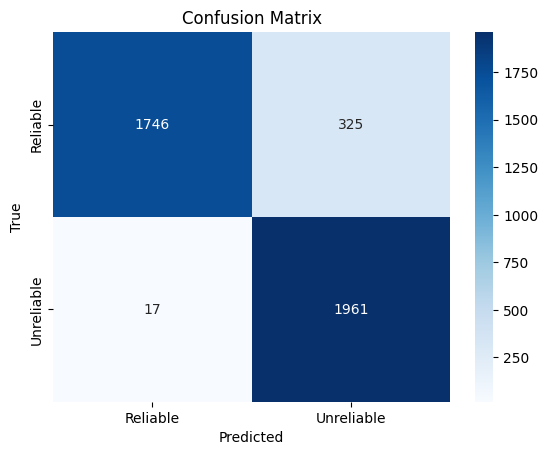

In [75]:
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Reliable', 'Unreliable'], yticklabels=['Reliable', 'Unreliable'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Top 10 words indicative of reliable news (according to model)

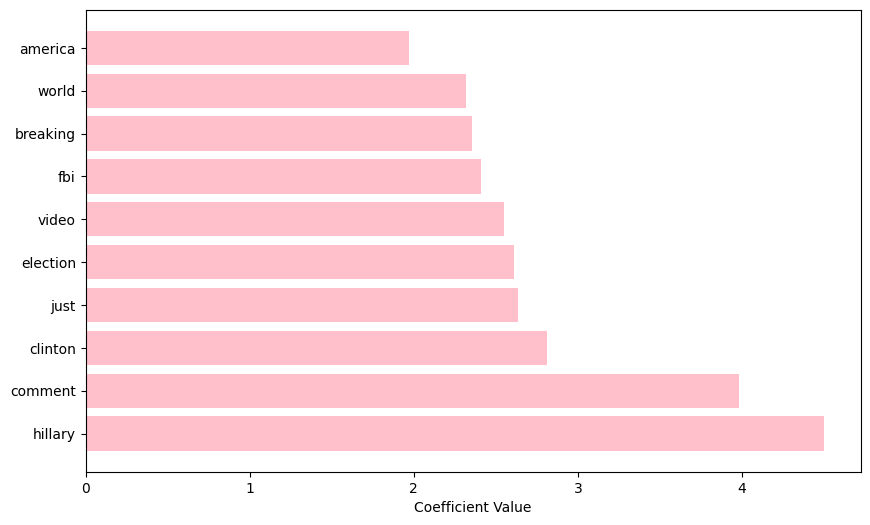

In [76]:
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = logreg_model.coef_.flatten()

feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
top_features = feature_importance.nlargest(10, 'Coefficient')

# print(top_features)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Coefficient'], color='pink')
plt.xlabel('Coefficient Value')
plt.show()

### Word Cloud Representation

This word cloud shows the most common words within titles deemed 'reliable'.

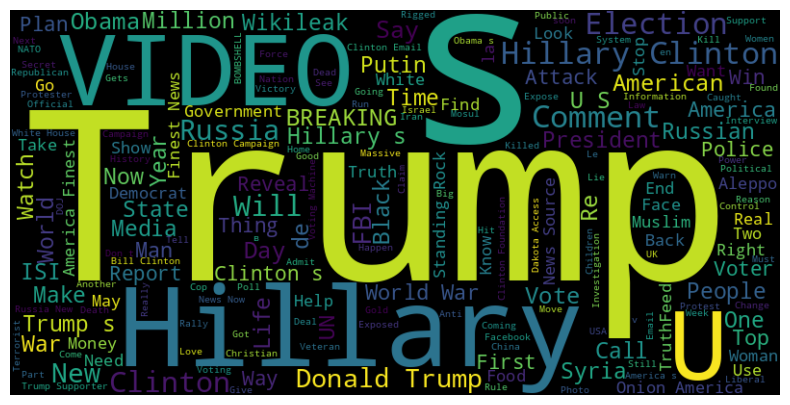

In [78]:
reliable_news_text = ' '.join(data[data['label'] == 1]['title'])
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(reliable_news_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Reliability and Title Length Correlation

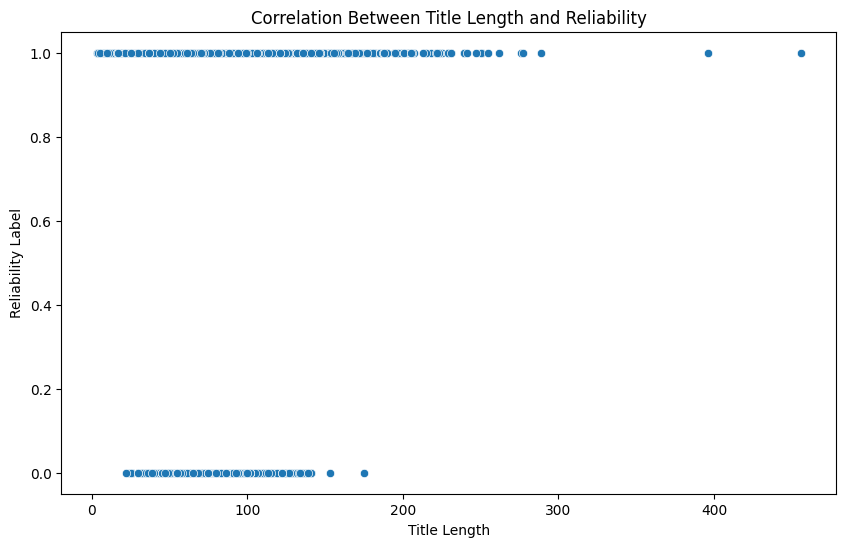

In [80]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='title_length', y='label', data=data)
plt.title('Correlation Between Title Length and Reliability')
plt.xlabel('Title Length')
plt.ylabel('Reliability Label')
plt.show()